### Задача

Уравнение Ван дер Поля - осциллятор с нелинейным затуханием  
$$
\frac{d^2 y}{dt^2} + a(y^2 - 1) \frac{dy}{dt} + y = 0, \quad y(0) = y_0 > 0, \quad y'(0) = 0, \quad 0 \leq t \leq 30, \quad 1 \leq a \leq 1000.
$$

1. Исследовать зависимость численных решений от параметров процессов;  
2. Исследовать сходимость численного решения по сетке;  
3. Использовать явный и неявный методы Рунге-Кутты 4-го порядка точности;  
4. Построить фазовый портрет.

In [2]:
# Используемые библиотеки
import numpy as np
import matplotlib.pyplot as plt

Перепишем уравнение Ван дер Поля в виде системы:
$$
\begin{equation*}
    \begin{cases}
      \frac{dy}{dt} = x, \\
      \frac{dx}{dt} = a(1 - y^2) x - y.
    \end{cases}\,
\end{equation*}
$$

In [3]:
# Уравнение Ван дер Поля
def van_der_pol(xy_vec, t, a):
    y, x = xy_vec
    dydt = [x, a * (1 - y**2) * x - y]
    return dydt

Явный метод Рунге-Кутты четвёртого порядка:
$$ k_1 = h f(t_n, u_n), $$
$$ k_2 = h f(t_n + \frac{h}{2}, u_n + \frac{k_1}{2}), $$
$$ k_3 = h f(t_n + \frac{h}{2}, u_n + \frac{k_2}{2}), $$
$$ k_4 = h f(t_n + h, u_n + k_3), $$
$$ u_{n+1} = u_n + \frac{k_1 + 2k_2 + 2k_3 + k_4}{6}. $$

In [4]:
# Явный метод Рунге-Кутты 4-го порядка
def explicit_rk4_method(f, xy_vec0, t):
    N = len(t)
    try:
        n = len(xy_vec0)
    except TypeError:
        n = 1
    xy_vec = np.zeros((N, n))
    xy_vec[0] = xy_vec0

    for i in range(N - 1):
        h = t[i + 1] - t[i]
        k1 = np.array(f(xy_vec[i], t[i]))
        k2 = np.array(f(xy_vec[i] + h / 2 * k1, t[i] + h / 2))
        k3 = np.array(f(xy_vec[i] + h / 2 * k2, t[i] + h / 2))
        k4 = np.array(f(xy_vec[i] + h * k3, t[i] + h))
        xy_vec[i + 1] = xy_vec[i] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return xy_vec

Неявный метод Рунге-Кутты четвёртого порядка:
$$ k_1 = f\left(t_n + \left(\frac{1}{2} - \frac{\sqrt{3}}{6} \right) h, u_n + h \left(\frac{1}{4} k_1 + \left( \frac{1}{4} - \frac{\sqrt{3}}{6} \right) k_2 \right) \right), $$
$$ k_2 = f\left(t_n + \left(\frac{1}{2} + \frac{\sqrt{3}}{6} \right) h, u_n + h \left(\left( \frac{1}{4} + \frac{\sqrt{3}}{6} \right) k_1 + \frac{1}{4} k_2 \right) \right), $$
$$ u_{n+1} = u_n + h \left( \frac{1}{2} k_1 + \frac{1}{2} k_2 \right). $$

In [5]:
# Коэффициенты метода Гаусса-Лежандра 4-го порядка
c = np.array([0.5 - np.sqrt(3)/6, 0.5 + np.sqrt(3)/6])
A = np.array([[0.25, 0.25 - np.sqrt(3)/6], 
              [0.25 + np.sqrt(3)/6, 0.25]])
b = np.array([0.5, 0.5])

# Невный метод Рунге-Кутты 4-го порядка
def implicit_rk4_method(f, xy_vec0, t):
    N = len(t)
    n = len(xy_vec0)
    xy_vec = np.zeros((N, n))
    xy_vec[0] = xy_vec0
    
    for i in range(N - 1):
        h = t[i + 1] - t[i]

        # Функция для решения системы нелинейных уравнений
        def equations(k):
            k = k.reshape(2, n)
            k1, k2 = k[0], k[1]
            return np.concatenate([
                k1 - f(xy_vec[i] + h * (A[0, 0] * k1 + A[0, 1] * k2), t[i] + c[0] * h),
                k2 - f(xy_vec[i] + h * (A[1, 0] * k1 + A[1, 1] * k2), t[i] + c[1] * h)
            ])

        # Начальное приближение для k1 и k2
        k_initial = np.array([f(xy_vec[i], t[i]), f(xy_vec[i], t[i])]).flatten()

        # Решение системы уравнений методом Ньютона
        from scipy.optimize import fsolve
        k_solution = fsolve(equations, k_initial)
        k_solution = k_solution.reshape(2, n)
        k1, k2 = k_solution[0], k_solution[1]

        # Обновление xy_vec
        xy_vec[i + 1] = xy_vec[i] + h * (b[0] * k1 + b[1] * k2)
        
        xy_vec[i+1] = xy_vec[i] + h * (b[0] * k_solution[0] + b[1] * k_solution[1])
    
    return xy_vec

Проверим, что методы выдают корректные результаты:

> Решение, найденное явным методом Рунге-Кутты четвертого порядка для a = 1: -1.7905260351010077


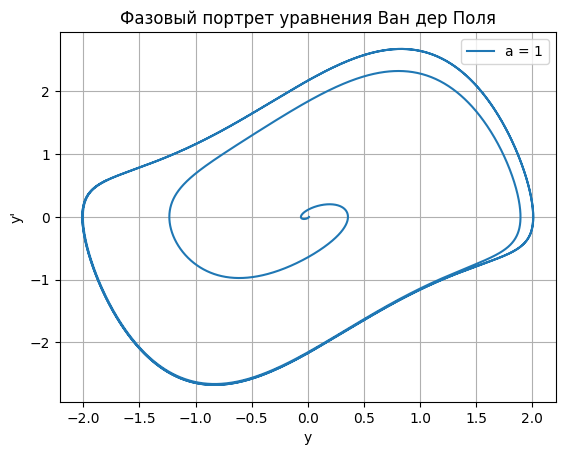

> Решение, найденное неявным методом Рунге-Кутты четвертого порядка для a = 1: -1.790526034999984


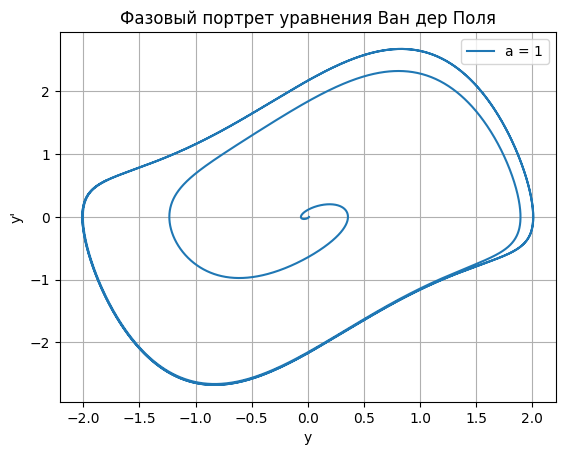

In [48]:
# Построение фазового портрета
def generate_phase_portrait(y, a):
    plt.plot(y[:, 0], y[:, 1], label=f'a = {a}')
    plt.title('Фазовый портрет уравнения Ван дер Поля')
    plt.xlabel('y')
    plt.ylabel("y'")
    plt.legend()
    plt.grid(True)
    plt.show()

# Начальные условия (y(0) = y_0 > 0, y'(0) = 0)
xy_vec0 = [0.01, 0.0]

# Параметр a
a_value = 1

from functools import partial
van_der_pol_a = partial(van_der_pol, a = a_value)

# Сетка
t = np.linspace(0, 30, 10000)

y_explicit = explicit_rk4_method(van_der_pol_a, xy_vec0, t)
print(f"> Решение, найденное явным методом Рунге-Кутты четвертого порядка для a = {a_value}: {y_explicit[-1, 0]}")
generate_phase_portrait(y_explicit, a_value)

y_implicit = implicit_rk4_method(van_der_pol_a, xy_vec0, t)
print(f"> Решение, найденное неявным методом Рунге-Кутты четвертого порядка для a = {a_value}: {y_implicit[-1, 0]}")
generate_phase_portrait(y_implicit, a_value)


#### Как будет вести себя система при изменении параметров?

##### Исследование уравнения Ван дер Поля

Уравнение Ван дер Поля

$$
y^{\prime\prime} + a (y^{2}-1)y^{\prime}+y=0, a > 0 
$$

Это можно интерпретировать как модель системы пружина-масса, где сила демпфирования зависит от положения (например, масса может двигаться через вязкую среду с переменной плотностью), а постоянная пружины (или восстанавливающая сила) зависит от того, насколько растянута пружина:

$$
y^{\prime\prime}+\underbrace{a(y^{2}-1)}_{{\rm демпфирование}}y^{\prime}+\underbrace{ y}_{\text{восстанавливающая}} = 0.
$$

Параметр $a$ перед нелинейным членом указывает на силу демпфирования.

Непосредственно анализируя уравнение, мы уже можем сделать некоторые общие выводы о поведении решений. Если решение $y\gg 1$, то восстанавливающая и демпфирующая силы велики, так что $|y(t)|$ должно уменьшаться со временем. Система ведет себя как сильно демпфированный осциллятор и рассеивает энергию.

Если решение мало $|y| < 1$, демпфирующая сила становится отрицательной, что должно приводить к увеличению $|y(t)|$ со временем. Энергия системы увеличивается.

##### Точки равновесия

Система имеет только одну точку равновесия:

$$
\begin{cases}
    y^{\prime} = x = 0\\
    x^{\prime} = a(1-y^{2})x - y = 0
\end{cases}
\quad\Leftrightarrow\qquad y=0,\;x=0.
$$

Если мы хотим проанализировать локальное поведение, нам, как обычно, нужно линеаризовать систему вокруг точки $(0,0)$. Якобиан системы в точке $(0,0)$ равен

$$
J=\begin{bmatrix}
    0 & 1 \\
    -1 & a
\end{bmatrix}
$$

с $\operatorname{trace} J=\mu$ и $\det J=1$. Его собственные значения $\lambda_{1,2}=\frac{a \pm \sqrt{a^{2}-4}}{2}$.

Следовательно, в зависимости от значения $a$ мы будем наблюдать следующие случаи:

$$
(0,0)=\begin{cases}
    \text{центр,} & \text{если } a = 0, \\
    \text{фокус,} & \text{если } 0 < a < 2, \\
    \text{дикритический узел,} & \text{если } a = 2, \\
    \text{неустойчивый узел,} & \text{если } a > 2.
\end{cases}
$$


#### Исследование зависимости численных решений от параметра $a$

Сначала исследуем зависимость численных решений от параметра $a$ для явного метода Рунге-Кутты:

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: -1.7905260349865506


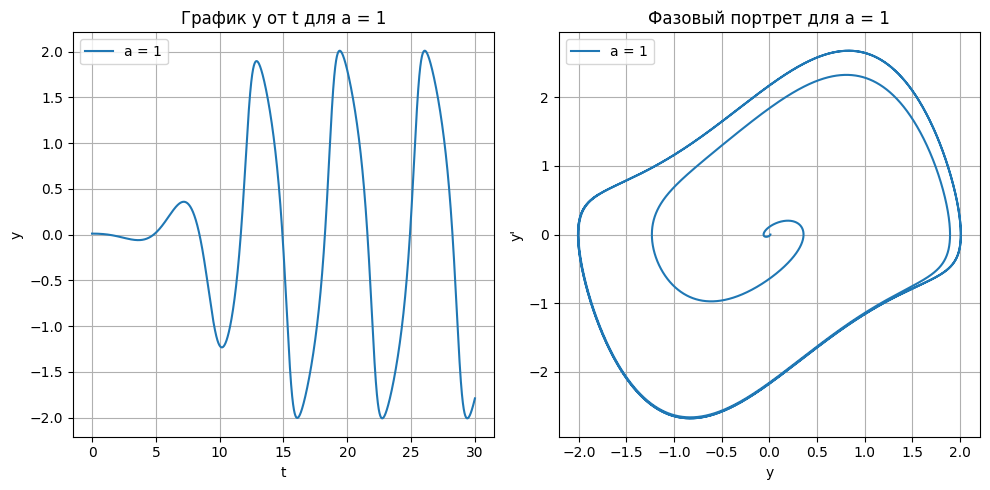

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2: 1.8639298617637492


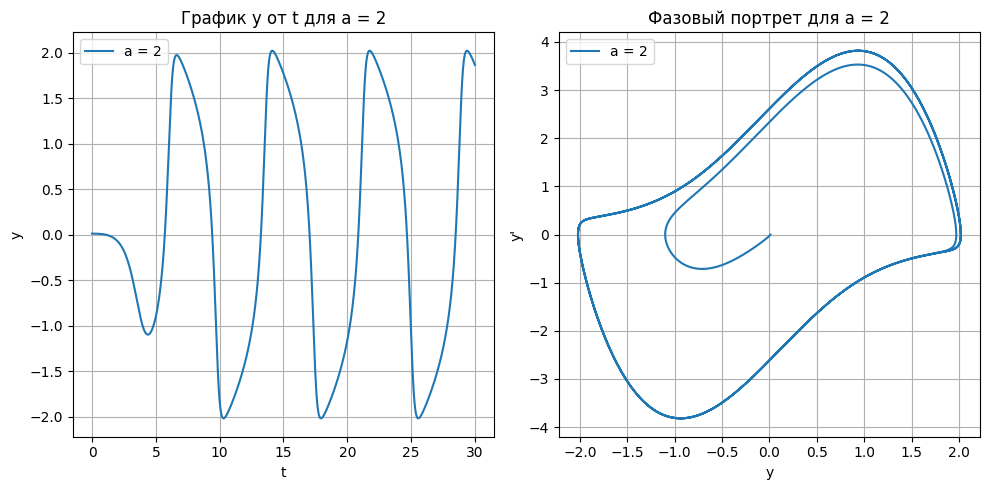

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 5: 1.8515720007532979


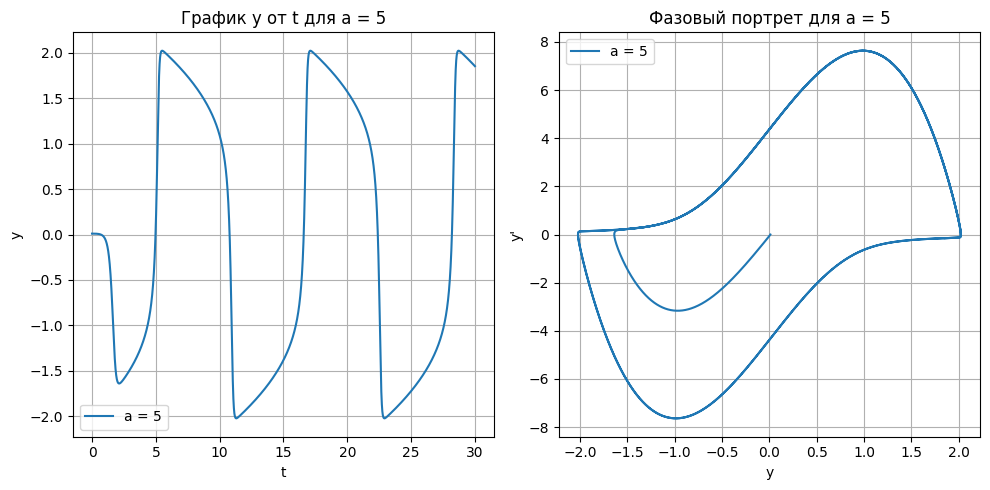

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 15: -1.5811441406497384


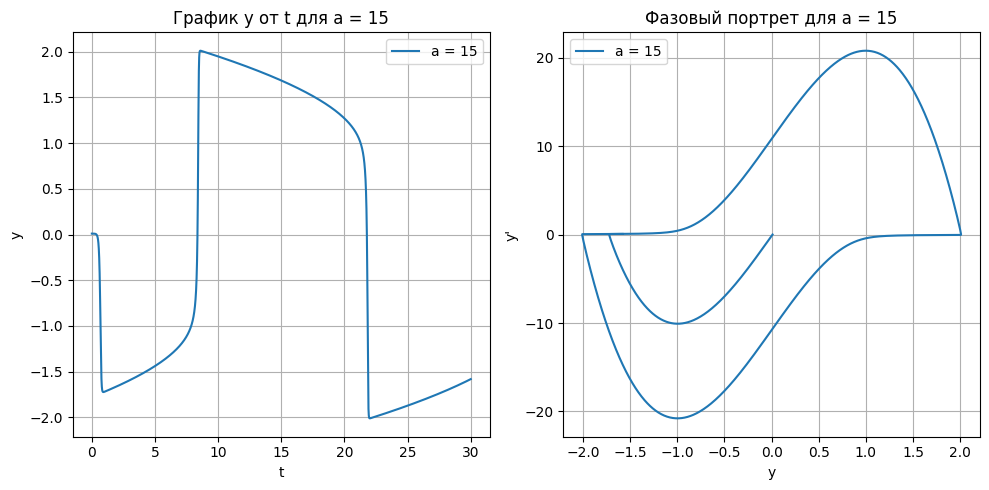

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 17: -1.7663370255569584


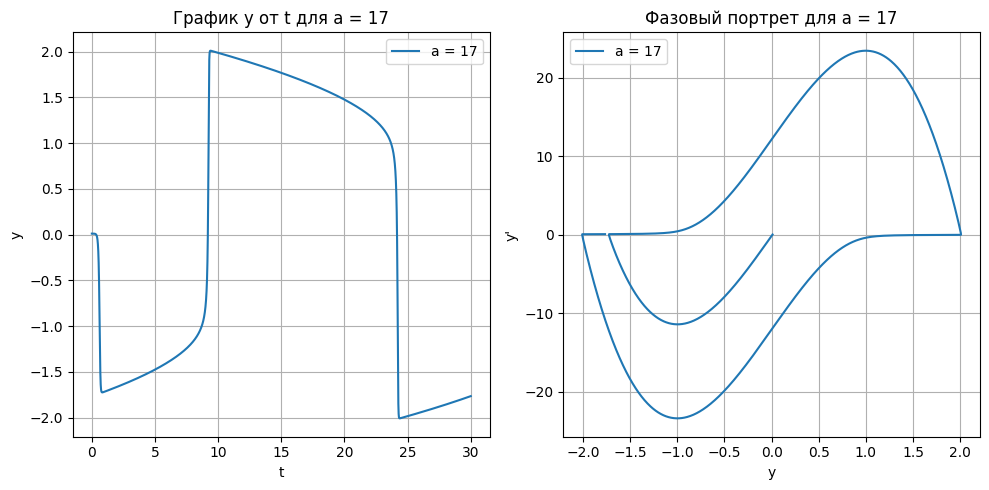

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 18: -1.8336028864215705


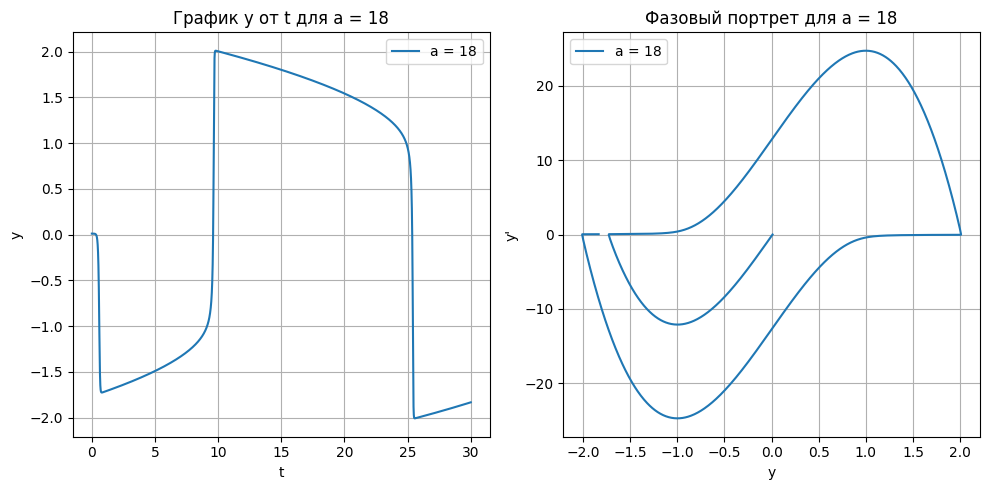

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 20: -1.939171991594952


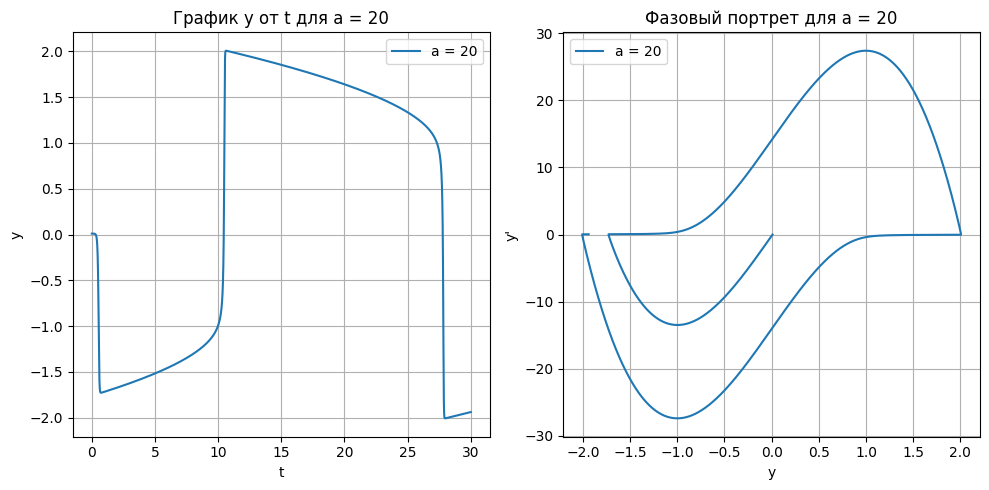

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 36: 1.7464044326855503


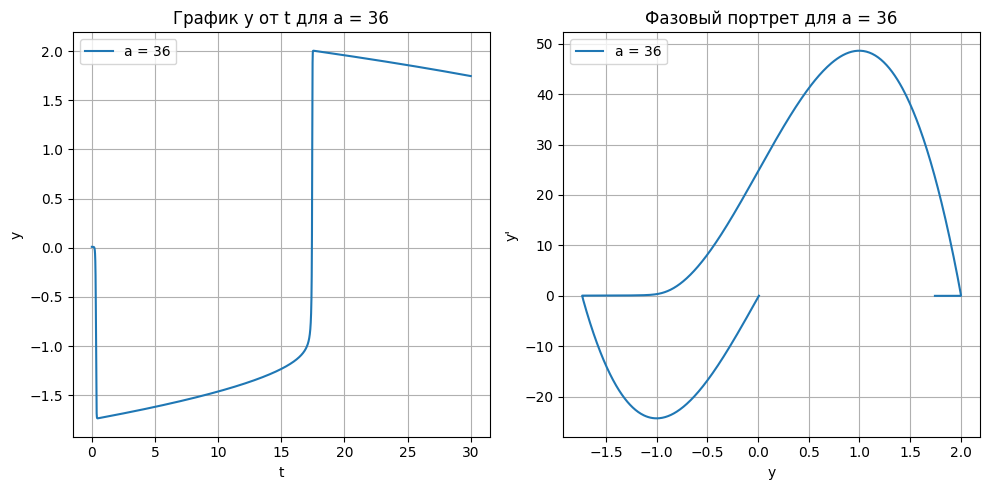

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 37: 1.7641754026585388


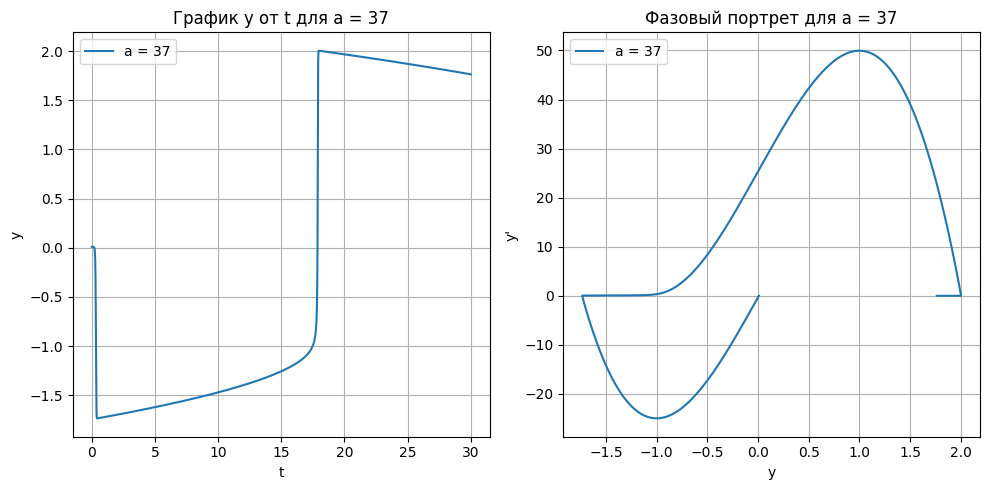

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 40: 1.8105847799719854


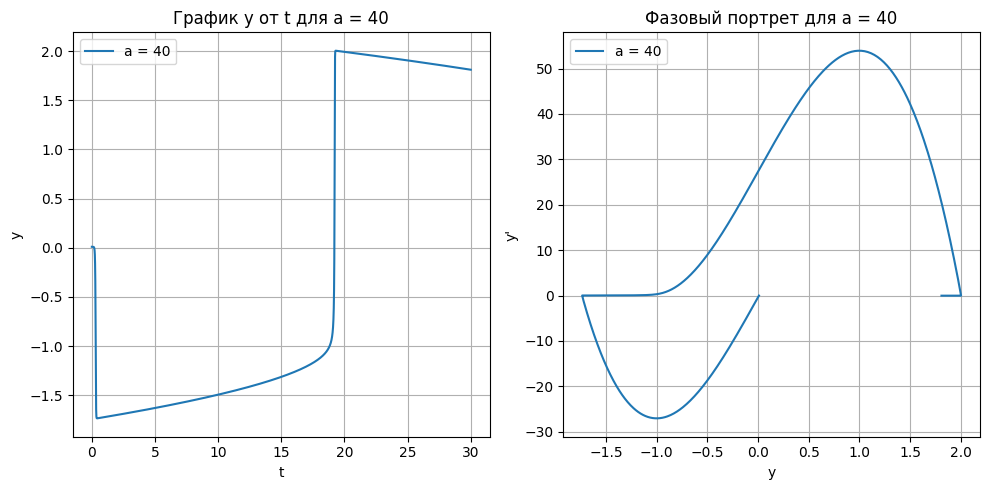

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 50: 1.9169786103873587


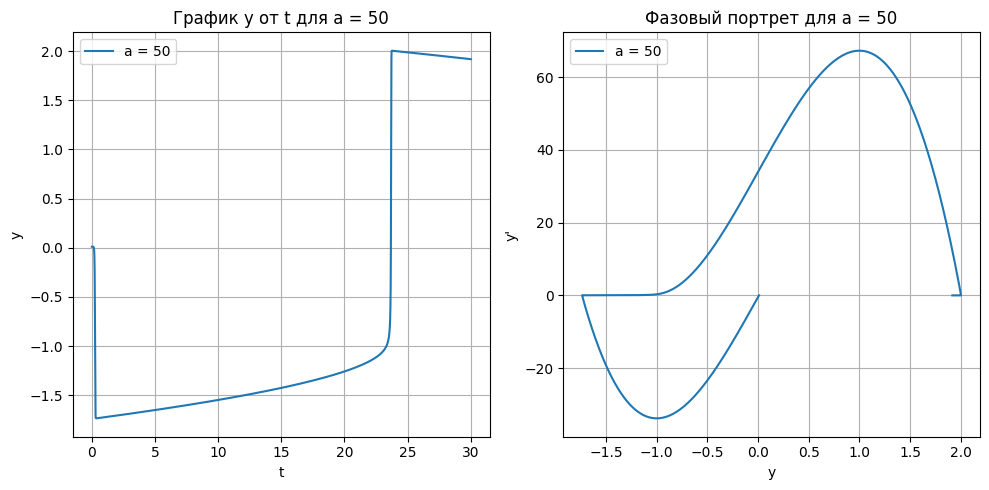

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 100: -1.4205238191611689


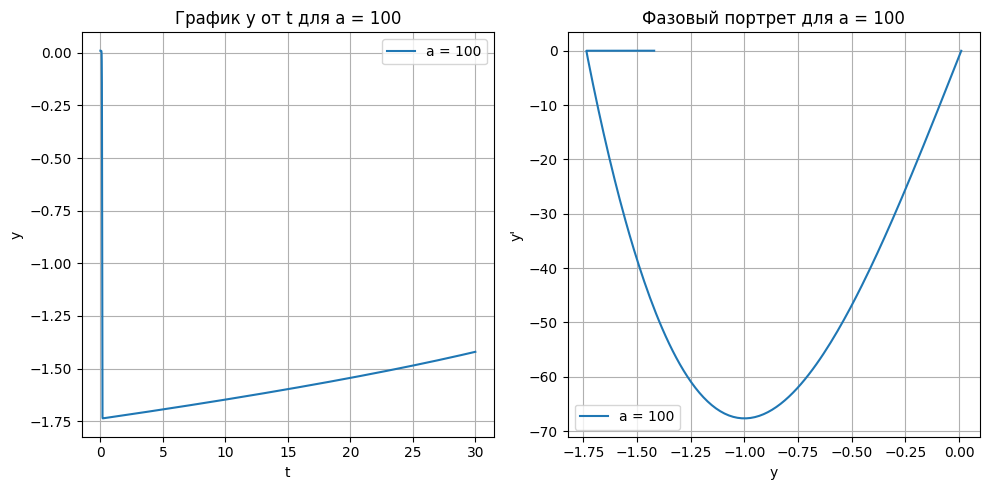

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 250: -1.6268922942964268


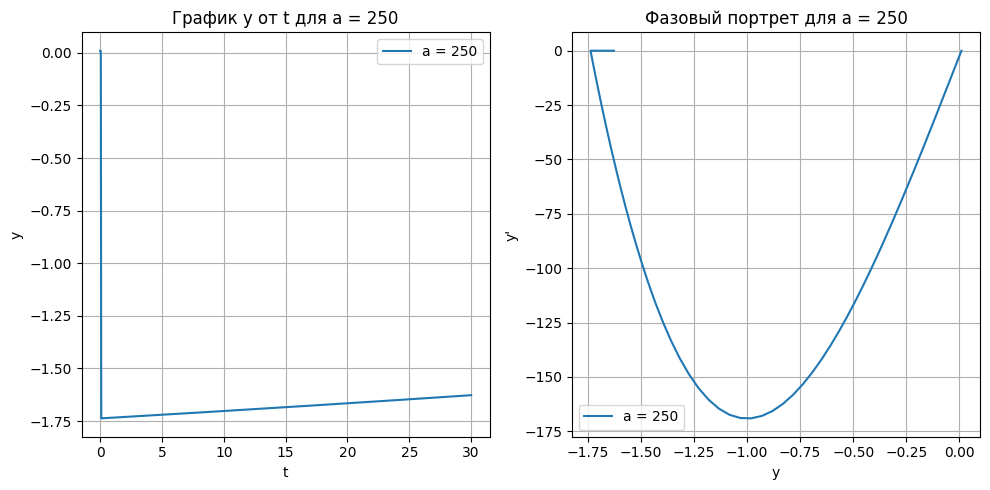

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 500: -1.6837930977445998


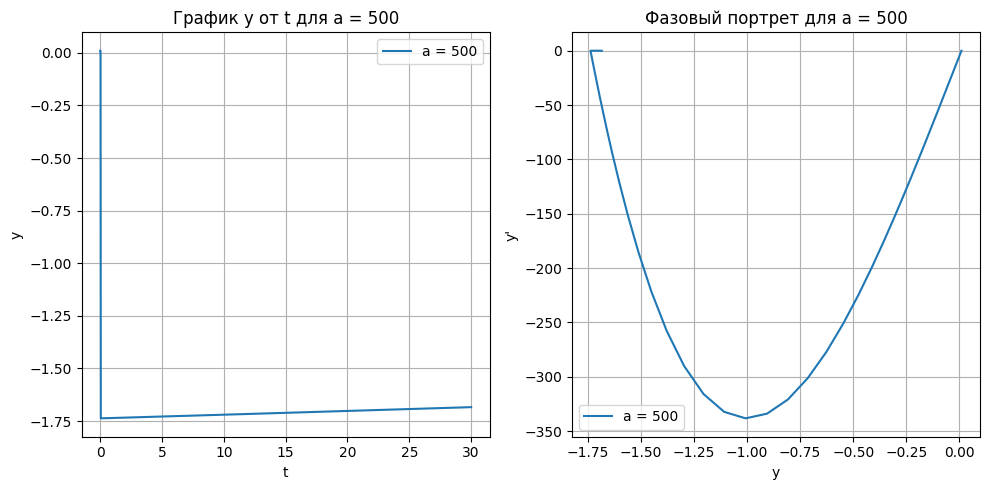

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1000: -1.7108375096134694


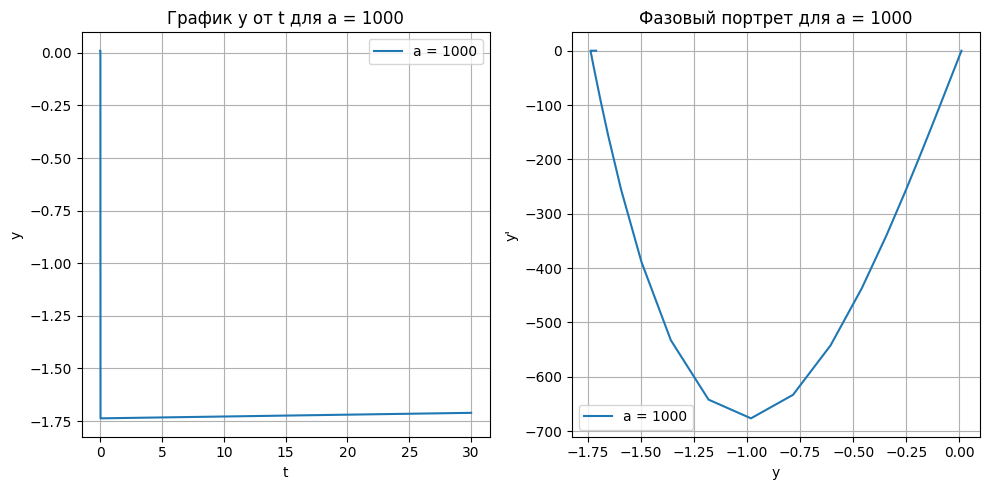

In [58]:
# Фиксируем параметры
t = np.linspace(0, 30, 100000)

xy_vec0 = [0.01, 0.0]
# xy_vec0 = [2.00, 0.0]

# Выбираем значения для исследования параметра a 
a_list = [1, 2, 5, 15, 17, 18, 20, 36, 37, 40, 50, 100, 250, 500, 1000]

# Создаем графики для каждого значения a
for a_value in a_list:
    van_der_pol_a = partial(van_der_pol, a=a_value)
    y = explicit_rk4_method(van_der_pol_a, xy_vec0, t)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Строим y(t)
    axs[0].plot(t, y[:, 0], label=f'a = {a_value}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    axs[0].set_title(f'График y от t для a = {a_value}')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('y')
    axs[0].grid(True)
    axs[0].legend()
    
    # Строим фазовый портрет
    axs[1].plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
    axs[1].set_title(f'Фазовый портрет для a = {a_value}')
    axs[1].set_xlabel('y')
    axs[1].set_ylabel('y\'')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


Изобразим на одном графике фазовые портреты решений, получаемых с помощью явного метода Рунге-Кутты, для разных $a$:

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.0: -1.7905260349865506
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.25: -1.9460375628270925
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5: 0.4562279988246908
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.75: 1.5609920958642287
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.99: 1.8551238978755131


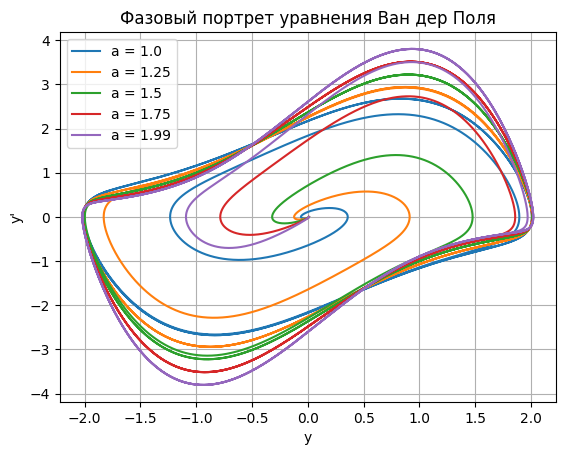

In [53]:
# Фиксируем параметры
t = np.linspace(0, 30, 100000)
xy_vec0 = [0.01, 0.0]

# Выбираем значения для исследования параметра a 
a_list = [1.00, 1.25, 1.50, 1.75, 1.99]

for a_value in a_list:
    van_der_pol_a = partial(van_der_pol, a = a_value)

    y = explicit_rk4_method(van_der_pol_a, xy_vec0, t)
    plt.plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()

> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y'(0)] = [0.01, 0.0]: 1.8639298617637492
> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y'(0)] = [0.05, 0.0]: 1.5055065856758374
> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y'(0)] = [0.25, 0.0]: 1.2704057511001037
> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y'(0)] = [0.5, 0.0]: 1.347237665796078
> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y'(0)] = [1.5, 0.0]: 1.8515136727952808


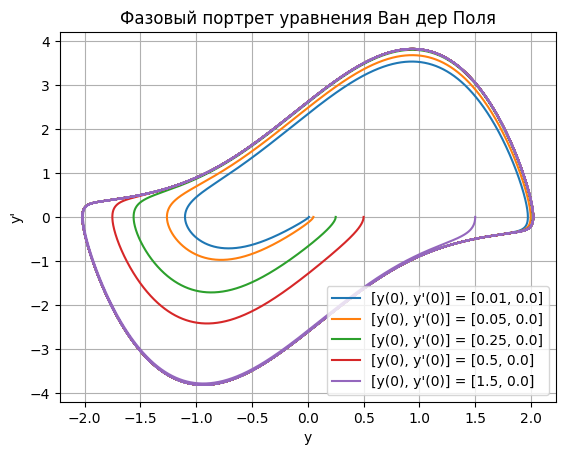

In [56]:
# Фиксируем параметры
t = np.linspace(0, 30, 100000)
xy_vec0_list = [0.01, 0.0], [0.05, 0.0], [0.25, 0.0], [0.50, 0.0], [1.50, 0.0]

# Рассмотрим дикритический узел
a_value = 2

for xy_vec0 in xy_vec0_list:
    van_der_pol_a = partial(van_der_pol, a = a_value)

    y = explicit_rk4_method(van_der_pol_a, xy_vec0, t)
    plt.plot(y[:, 0], y[:, 1], label=f'[y(0), y\'(0)] = {xy_vec0}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для [y(0), y\'(0)] = {xy_vec0}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.01: 1.8725907207619907
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5: 0.3567845788676711
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3.0: -1.47132061152121
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 5.0: 1.8515720007532979
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 10.99: 1.8676290925335972


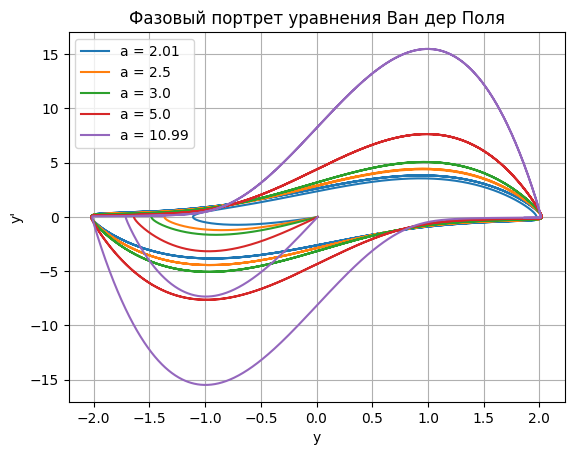

In [57]:
# Фиксируем параметры
t = np.linspace(0, 30, 100000)
xy_vec0 = [0.01, 0.0]

# Выбираем значения для исследования параметра a 
a_list = [2.01, 2.50, 3.00, 5.00, 10.99]

for a_value in a_list:
    van_der_pol_a = partial(van_der_pol, a = a_value)

    y = explicit_rk4_method(van_der_pol_a, xy_vec0, t)
    plt.plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()

Теперь исследуем зависимость численных решений от параметра $a$ для неявного метода Рунге-Кутты:

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: -2.0079102285309554


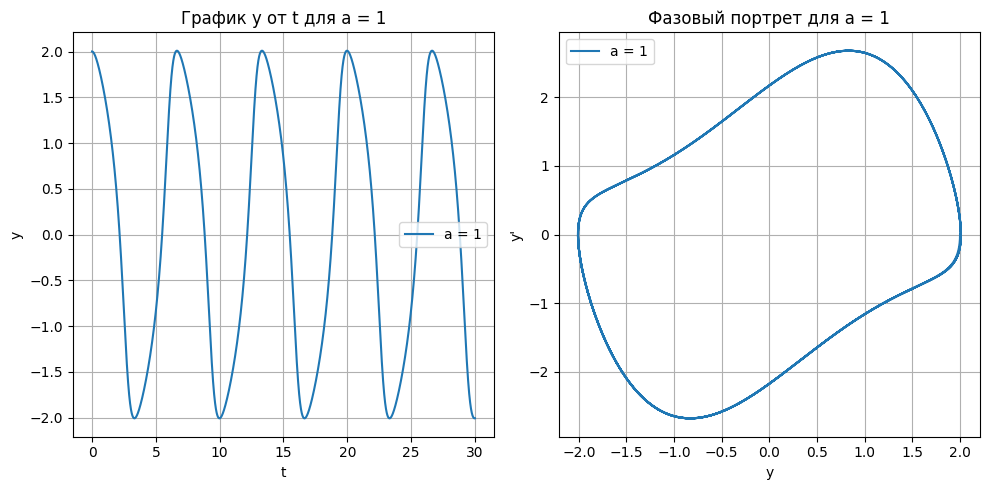

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 5: -1.8739619570503931


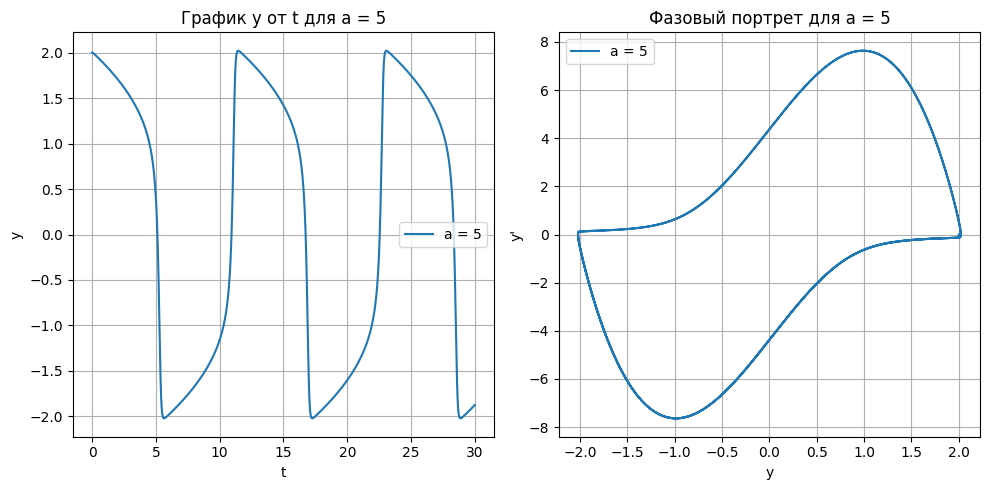

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 15: 1.8506679229154013


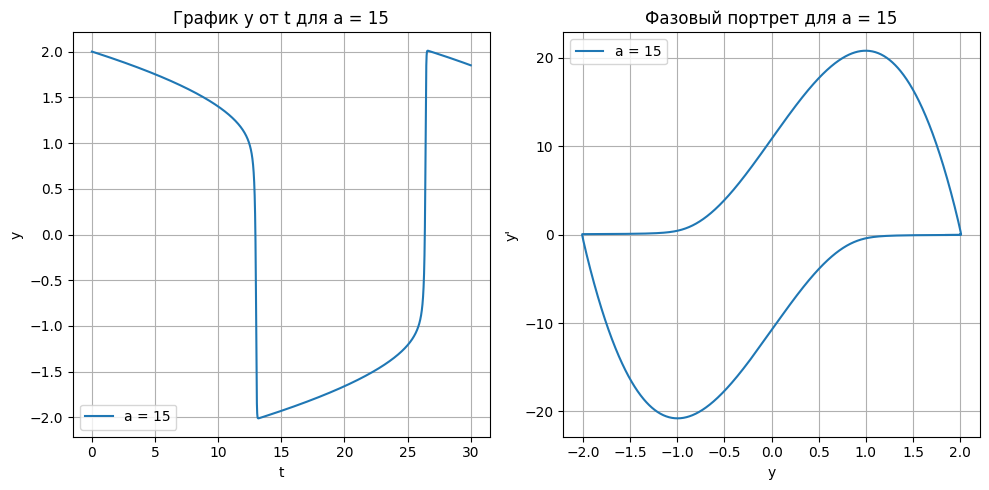

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 17: 1.9991723631349307


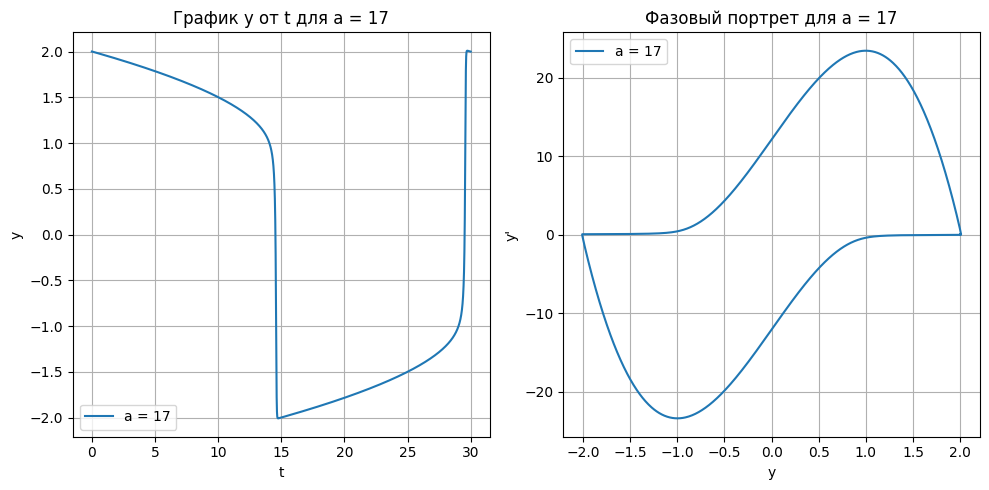

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 18: -1.1540830534028785


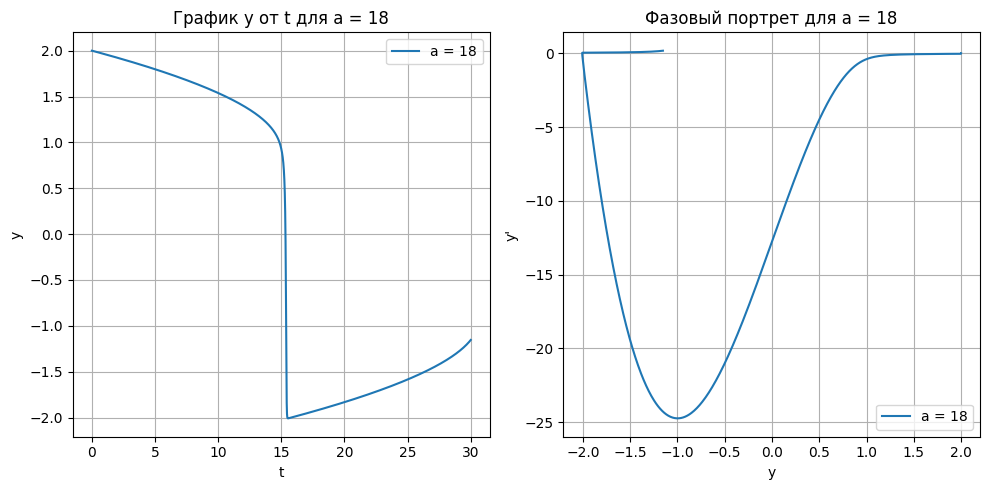

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 20: -1.444786178758097


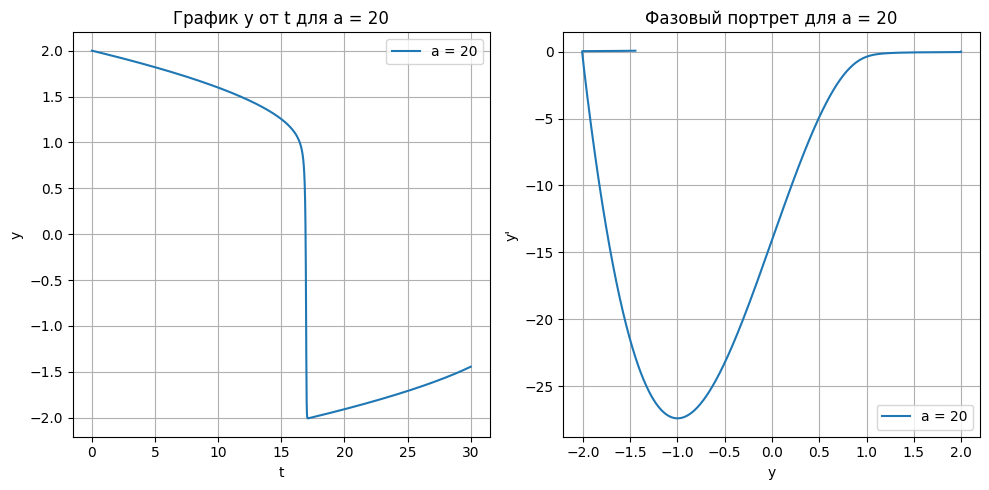

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 36: -2.001195665923264


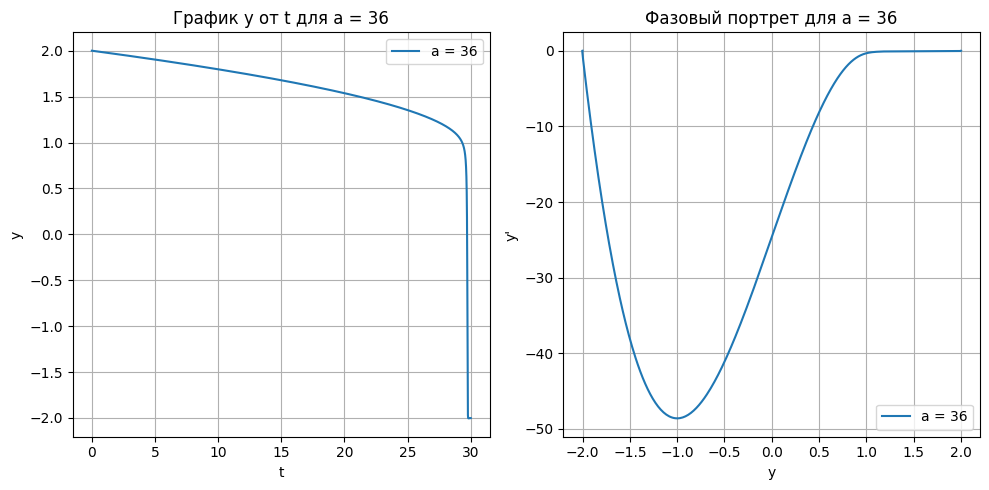

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 37: 1.0330840728501116


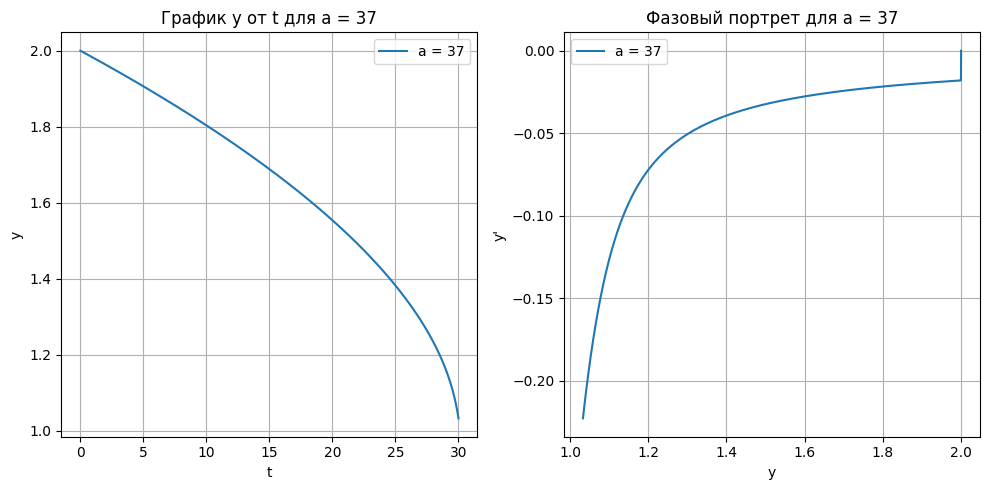

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 40: 1.2491596391754047


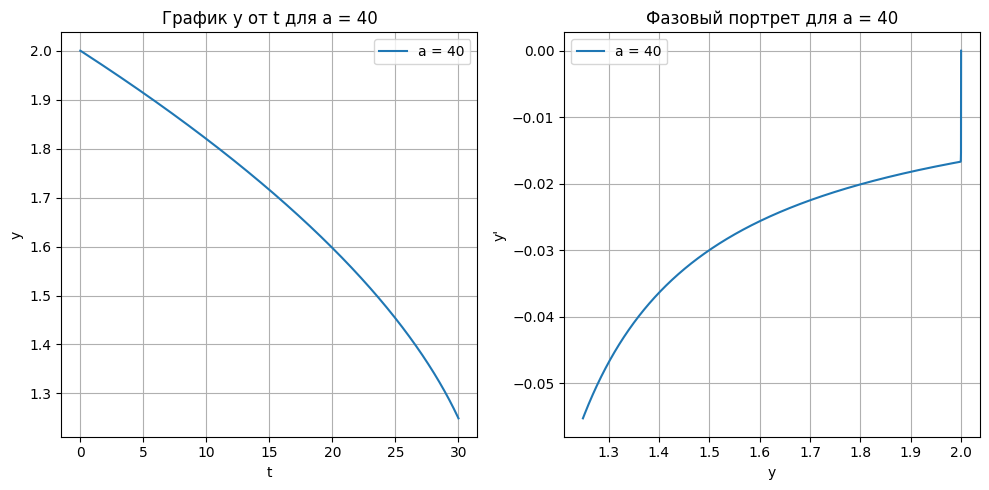

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 50: 1.4849057585657477


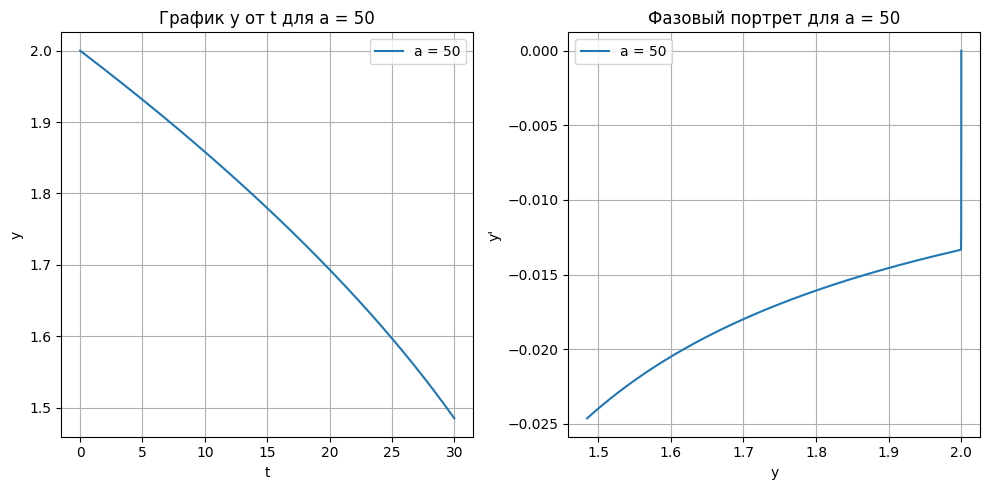

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 100: 1.7794315698758099


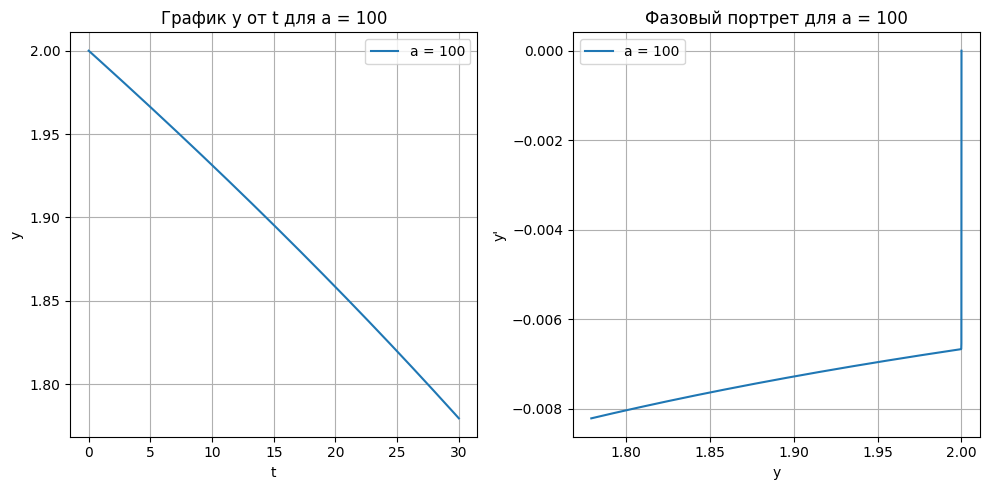

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 250: 1.91712578537933


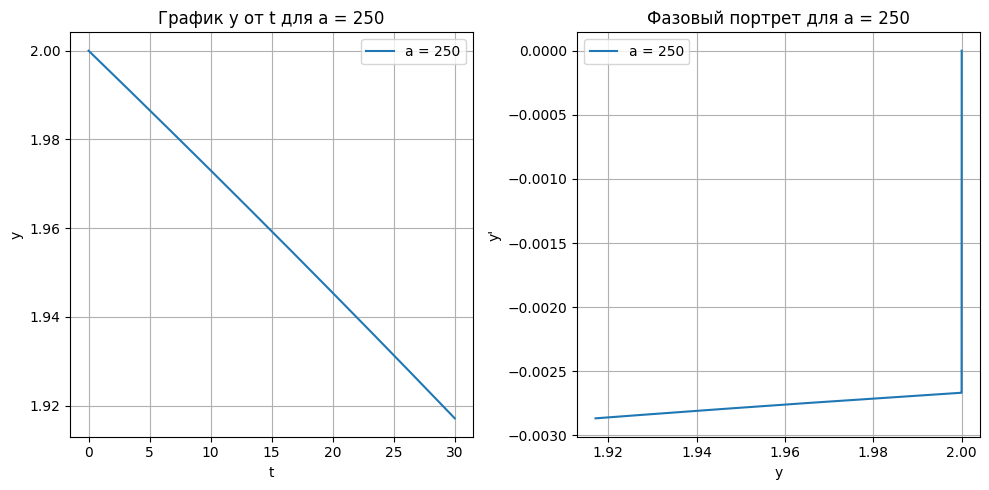

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 500: 1.9593091253236259


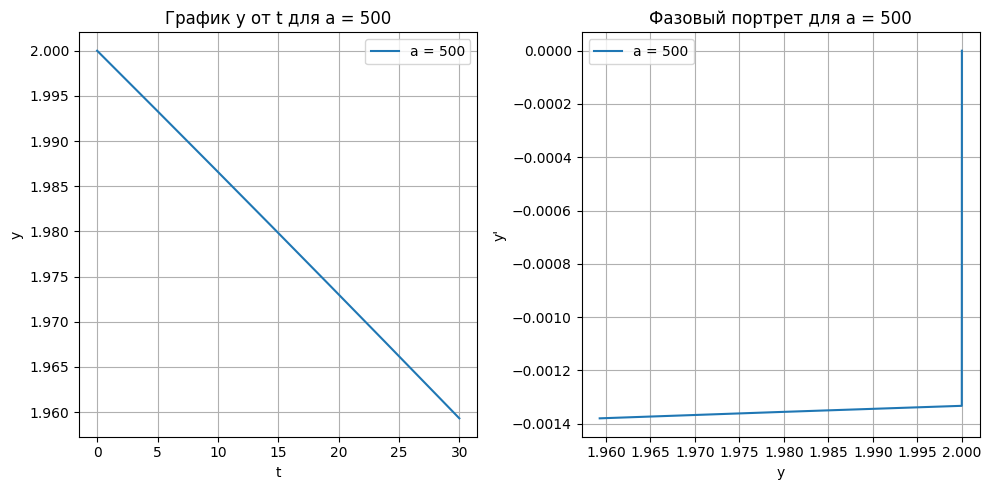

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1000: 1.979830492628555


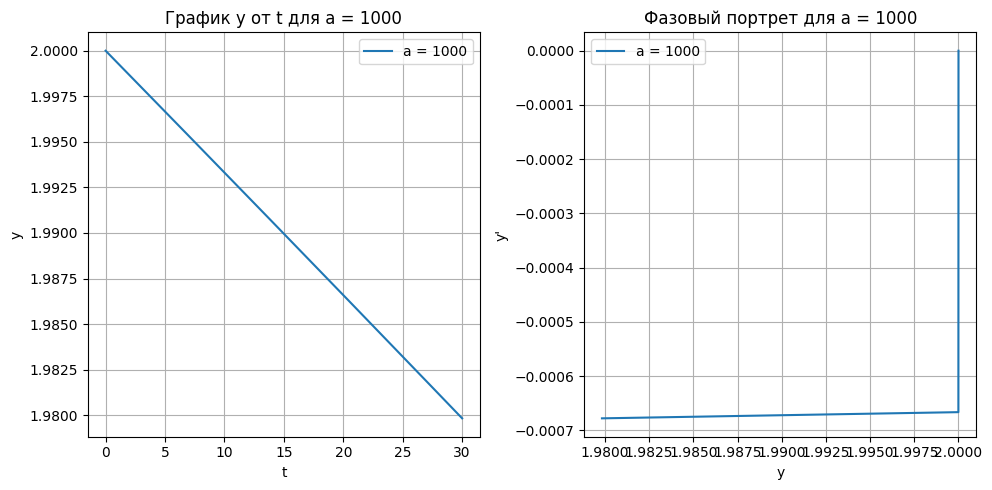

In [59]:
# Фиксируем параметры
t = np.linspace(0, 30, 100000)
xy_vec0 = [2.0, 0.0]

# Выбираем значения для исследования параметра a 
a_list = [1, 5, 15, 17, 18, 20, 36, 37, 40, 50, 100, 250, 500, 1000]

# Создаем графики для каждого значения a
for a_value in a_list:
    van_der_pol_a = partial(van_der_pol, a=a_value)
    y = implicit_rk4_method(van_der_pol_a, xy_vec0, t)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Строим y(t)
    axs[0].plot(t, y[:, 0], label=f'a = {a_value}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    axs[0].set_title(f'График y от t для a = {a_value}')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('y')
    axs[0].grid(True)
    axs[0].legend()
    
    # Строим фазовый портрет
    axs[1].plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
    axs[1].set_title(f'Фазовый портрет для a = {a_value}')
    axs[1].set_xlabel('y')
    axs[1].set_ylabel('y\'')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 0.01: -1.790527149413722
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 0.5: -1.4198178880750152
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 0.9: -1.5335039701696551
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 1.0: -1.574597672368508
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 1.5: -1.8079489929526515
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1 и y(0) = 2.0: -2.007910429467446


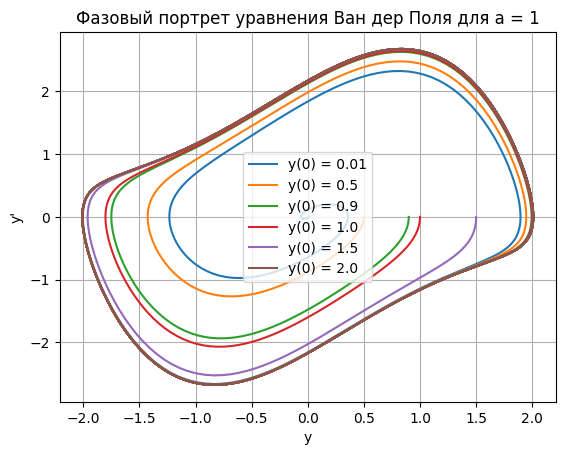

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 0.01: 0.45623963313201116
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 0.5: -1.946335209268005
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 0.9: -1.5293663386566727
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 1.0: -1.3014287878298247
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 1.5: 0.15329296818339694
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1.5 и y(0) = 2.0: 1.217272439224653


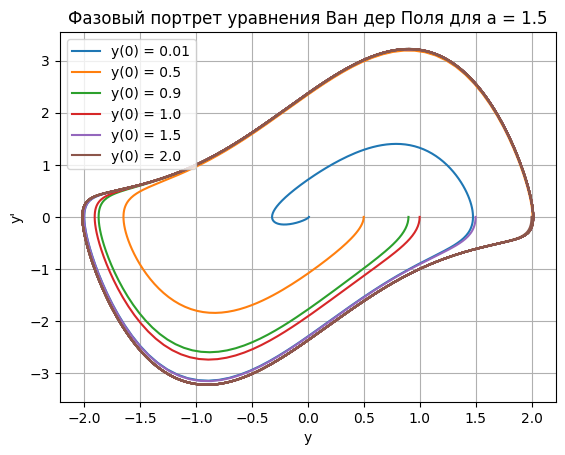

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 0.01: 1.8639370011005014
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 0.5: 1.3472506295266042
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 0.9: 1.5491014947836859
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 1.0: 1.5981757143120028
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 1.5: 1.8515221991988169
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2 и y(0) = 2.0: 1.4626636167413982


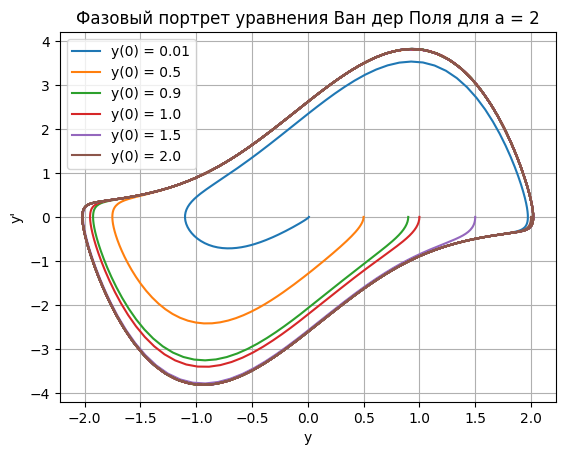

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 0.01: 0.35663012873116734
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 0.5: 2.0201991954508536
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 0.9: 1.021836130732178
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 1.0: 0.4890878594773159
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 1.5: -0.957972486365032
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 2.5 и y(0) = 2.0: -1.6798293518801766


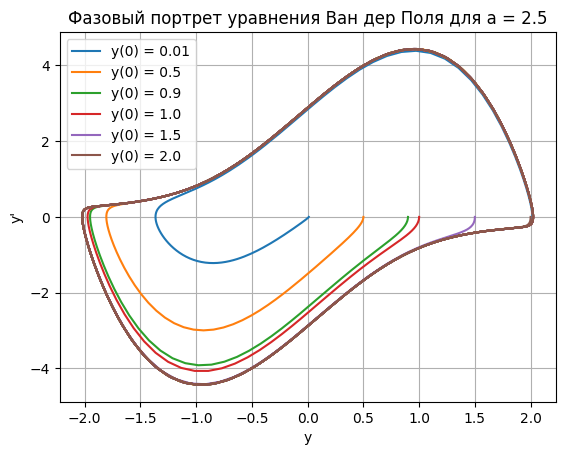

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 0.01: -1.4713519771041204
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 0.5: -1.3772154980658233
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 0.9: -1.584615131341747
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 1.0: -1.6283737016361641
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 1.5: -1.8626899013569673
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 3 и y(0) = 2.0: 0.45172162961564116


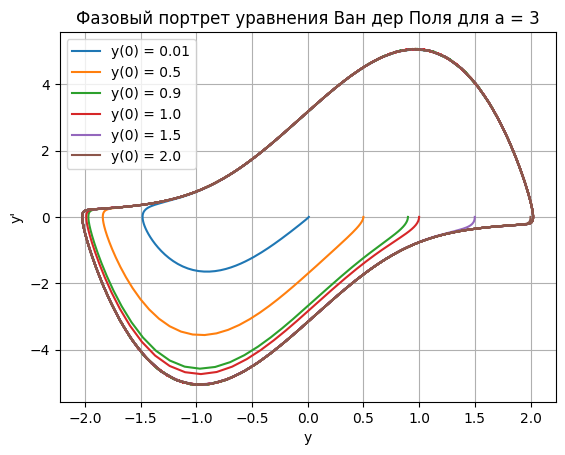

In [65]:
# Фиксируем параметры
t = np.linspace(0, 30, 1000)

a_list = [1, 1.5, 2, 2.5, 3]

y_list = [0.01, 0.50, 0.90, 1.00, 1.50, 2.00]

for a_value in a_list:
    for y_0 in y_list:
        van_der_pol_a = partial(van_der_pol, a = a_value)
        xy_vec0 = [y_0, 0.0]

        y = explicit_rk4_method(van_der_pol_a, xy_vec0, t)
        plt.plot(y[:, 0], y[:, 1], label=f'y(0) = {y_0}')
        print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value} и y(0) = {y_0}: {y[-1, 0]}")

    plt.title(f'Фазовый портрет уравнения Ван дер Поля для a = {a_value}')
    plt.legend()
    plt.xlabel('y')
    plt.ylabel("y'")
    plt.legend()
    plt.grid(True)
    plt.show()

##### Объясним полученные результаты: